In [1]:
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
load_dotenv()
import os
from datetime import datetime, timedelta
from tqdm import tqdm
from processor.processor import Processor as p
from database.adatabase import ADatabase

In [2]:
market = ADatabase("market")
market.connect()
index = market.retrieve("sp500")
market.disconnect()

In [3]:
start = datetime(2020,1,1)
end = datetime.now()

In [4]:
prices = []
date = start
market.connect()
for ticker in tqdm(index["ticker"]):
    try:
        price = market.query("prices",{"ticker":ticker})
        price = p.column_date_processing(price)
        price.sort_values("date",inplace=True)
        prices.append(price)
    except Exception as e:
        print(str(e))
market.disconnect()

 13%|███████████████████████▋                                                                                                                                                                     | 63/503 [00:03<00:19, 22.07it/s]

'date'


 15%|████████████████████████████▉                                                                                                                                                                | 77/503 [00:03<00:20, 20.58it/s]

'date'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:25<00:00, 19.59it/s]

'date'


In [5]:
market_prices = pd.concat(prices)

In [6]:
def calculate_indicators(price, timeframe):
    """Calculate indicators for a single ticker."""
    price = price.sort_values("date")
    price["sma"] = price["adjclose"].rolling(timeframe).mean() / price["adjclose"]
    price["ema"] = price["adjclose"].ewm(span=timeframe, adjust=False).mean() / price["adjclose"]

    delta = price["adjclose"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(timeframe).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(timeframe).mean()
    rs = gain / loss
    price["rsi"] = 100 - (100 / (1 + rs))

    price["std"] = price["adjclose"].rolling(timeframe).std()
    price["bollinger_upper"] = (price["sma"] + 2 * price["std"]) / price["sma"]
    price["bollinger_lower"] = (price["sma"] - 2 * price["std"]) / price["sma"]

    price["pct_change"] = price["adjclose"].pct_change(periods=timeframe)
    price["coev"] = price["adjclose"].rolling(timeframe).std() / price["adjclose"].rolling(timeframe).mean()
    price["year"] = price["date"].dt.year
    price["week"] = [x.week for x in price["date"]]
    price["sell_price"] = price["adjclose"]
    return price.dropna()

In [7]:
signals = ["sma"
           ,"ema","rsi","bollinger_upper","bollinger_lower","pct_change","coev"
          ]
ascendings = [True,False]
timeframes = [5,10,20,60,100]

In [27]:
analysis = []
for stocks in [1,5]:
    for timeframe in tqdm(timeframes):
        sim = market_prices.sort_values("date").groupby("ticker").apply(lambda x: calculate_indicators(x,timeframe)).reset_index(drop=True).sort_values("date")
        for signal in signals:
            for ascending in ascendings:
                opportunities = sim[sim["year"]>=2020].groupby(["year","week","ticker"]).agg({"date":"last","adjclose":"first","sell_price":"last",signal:"first"}).reset_index()
                # trades = opportunities.sort_values(signal,ascending=ascending).groupby(["year","week"]).first().reset_index()
                trades = opportunities.sort_values(signal,ascending=ascending).groupby(["year","week"]).nth([i for i in range(stocks)]).reset_index()
                trades.sort_values("date",inplace=True)
                trades["return"] = trades["sell_price"] / trades["adjclose"]
                trades = trades.groupby("date").agg({"return":"mean"}).reset_index()
                trades["pnl"] = trades["return"].cumprod()
                pnl = trades["pnl"].iloc[-1]
                wins = trades[trades["return"]>=1]
                losses = trades[trades["return"]<1]
                average_gain = wins["return"].mean()
                average_loss = losses["return"].mean()
                analysis.append({
                    "stocks":stocks,
                    "timeframe":timeframe,
                    "signal":signal,
                    "ascending":ascending,
                    "pnl":trades["pnl"].iloc[-1] * 1000 - 1000,
                    "volatility": trades["return"].std(),
                    "average_gain":average_gain,
                    "average_loss":average_loss,
                    "w/l":wins.index.size / losses.index.size
                })

  0%|                                                                                                                                                                                                        | 0/5 [00:00<?, ?it/s]C:\Users\eric\AppData\Local\Temp\ipykernel_16720\1476477003.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sim = market_prices.sort_values("date").groupby("ticker").apply(lambda x: calculate_indicators(x,timeframe)).reset_index(drop=True).sort_values("date")
 20%|██████████████████████████████████████▍                                                                                                                                                         | 1/5 [00:12<00:4

In [28]:
a = pd.DataFrame(analysis)

In [29]:
a.sort_values("pnl",ascending=False).head(10)

,stocks,timeframe,signal,ascending,pnl,volatility,average_gain,average_loss,w/l
38,1,20,pct_change,True,36672.410549,0.233222,1.085787,0.954383,1.147541
31,1,20,ema,False,17160.101542,0.231076,1.080896,0.952079,1.165289
3,1,5,ema,False,15131.496317,0.073400,1.057188,0.959473,1.220339
17,1,10,ema,False,12107.459038,0.074821,1.059071,0.954822,1.239316
15,1,10,sma,False,11959.618936,0.076865,1.060206,0.955336,1.201681
59,1,100,ema,False,8276.586836,0.087992,1.063577,0.949201,1.220339
115,5,60,ema,False,6706.442394,0.080611,1.047122,0.968159,1.147541
57,1,100,sma,False,6303.292844,0.088886,1.062889,0.950969,1.165289
45,1,60,ema,False,6011.406993,0.088085,1.064141,0.951849,1.112903
66,1,100,pct_change,True,5872.746621,0.076190,1.056311,0.956227,1.165289


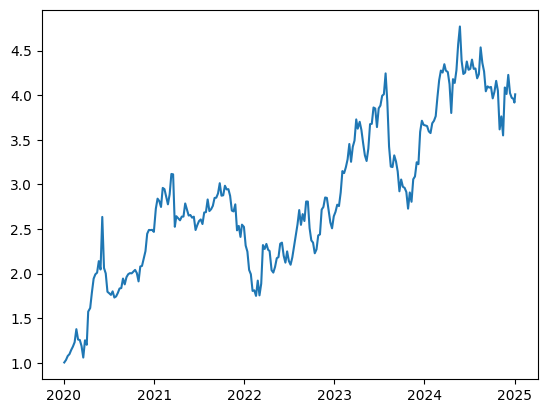

In [30]:
plt.plot(trades["date"],trades["pnl"])
plt.show()